# Init

In [1]:
using Plots
using Plots.PlotMeasures
using CSV
using DataFrames
using FFTW
using Printf
using Images
using Statistics

In [2]:
ind_mod(n, m) = (n+m-1)%m+1
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))];

function show_lattice(lattice)
    bw_array = Gray.((lattice .+ 1) ./ 2)
    img = reshape(bw_array, L, L)
    display(img)
end;

# Analyze Data - Single Trial

This is an example for analyzing the results of the simulation.

Plots in the summary were made by averaging over multiple trials and measurements.

-----------------------

Load trial metadata and magnetization measurements

In [3]:
L = 100
N = L^2

base_path = "meas_trials"
trial_dir = "trial_9413_L_100_Ts_38"
M_file = "M_meas.csv"
setup_file = "setup.csv"
M_path = "$(base_path)\\$(trial_dir)\\$(M_file)"
setup_path = "$(base_path)\\$(trial_dir)\\$(setup_file)"

M_df = CSV.read(M_path, DataFrame)
setup_df = CSV.read(setup_path, DataFrame)
T_arr, M_arr = M_df.T, M_df.M
setup_df.tot_sweeps = setup_df.equ_sweeps .+ setup_df.meas_sweeps .* (setup_df.n_meas .- 1)
setup_df.start_idx = cumsum(vcat(1, setup_df.tot_sweeps[1:end-1]))
setup_df.end_idx = cumsum(setup_df.tot_sweeps);

## Meas Example

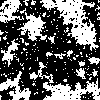

In [4]:
meas_num = 1
meas_T = 2.28
meas_path = "$(base_path)\\$(trial_dir)\\T_$(meas_T)_meas_$(meas_num).csv"

data = Matrix(CSV.read(meas_path, DataFrame, header=false))
show_lattice(data)

## Magnetization

Plot the magnetization per spin by sweep of the entire trial, across different temperatures

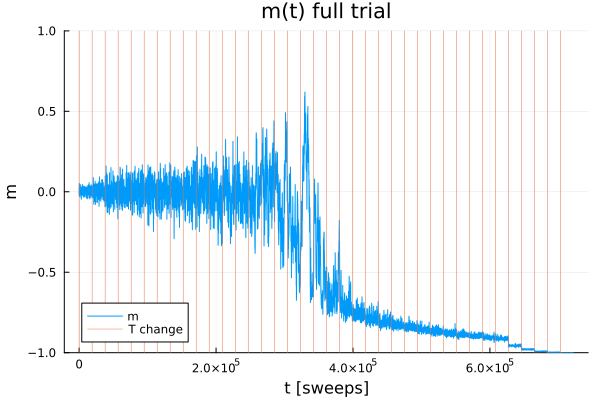

In [5]:
plot(1:100:length(M_arr), M_arr[1:100:end]/N, title="m(t) full trial", xlabel="t [sweeps]", ylabel="m", label="m", ylim=(-1, 1))
vline!(setup_df.start_idx .- 0.5, linewidth=0.5, label="T change")

Plot the temperature by sweep

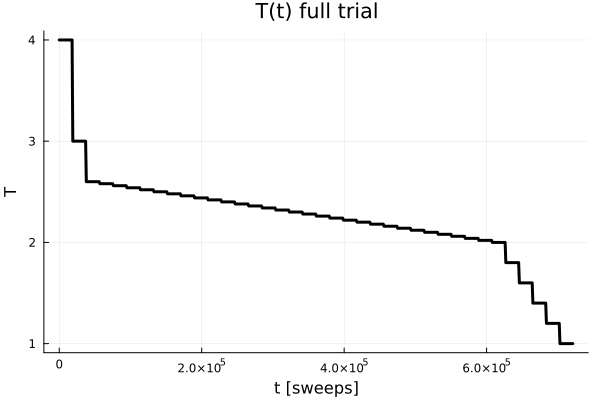

In [6]:
plot(1:1000:length(T_arr), T_arr[1:1000:end], title="T(t) full trial", xlabel="t [sweeps]", ylabel="T", linewidth=3, color=:black, legend=false)

Plot the magnetization per spin by sweep for a single section of the trial with a single temperature

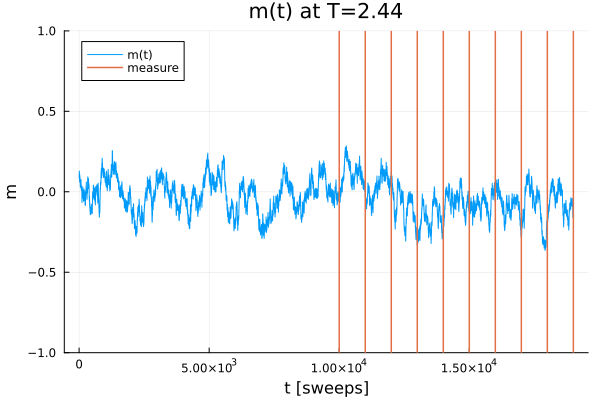

In [7]:
sect_idx = 11
sect_start = setup_df.start_idx[sect_idx]
sect_end = setup_df.end_idx[sect_idx]
sect = sect_start:sect_end
sect_T = setup_df.T[sect_idx]
sect_m = M_arr[sect] / N

sect_equ_sweeps = setup_df.equ_sweeps[sect_idx]
sect_meas_sweeps = setup_df.meas_sweeps[sect_idx]
sect_n_meas = setup_df.n_meas[sect_idx]

plot(sect_m, title="m(t) at T=$sect_T", xlabel="t [sweeps]", ylabel="m", ylim=(-1,1), label="m(t)")
vline!([sect_equ_sweeps + sect_meas_sweeps * n for n in 0:(sect_n_meas-1)], linewidth=1.5, label="measure")

Same, for absolute magnetization per spin, with smoothing

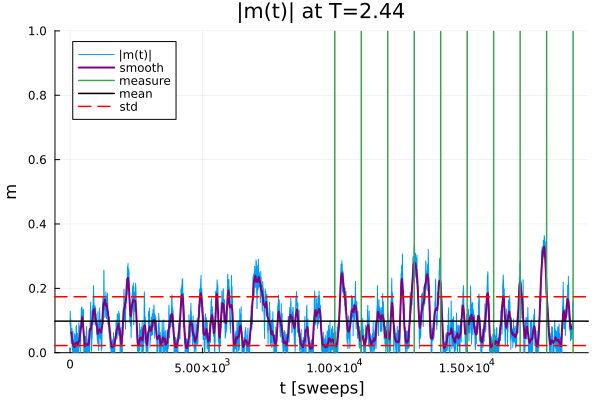

In [8]:
sect_idx = 11
sect_start = setup_df.start_idx[sect_idx]
sect_end = setup_df.end_idx[sect_idx]
sect = sect_start:sect_end
sect_T = setup_df.T[sect_idx]
sect_m = abs.(M_arr[sect] / N)

sect_equ_sweeps = setup_df.equ_sweeps[sect_idx]
sect_meas_sweeps = setup_df.meas_sweeps[sect_idx]
sect_n_meas = setup_df.n_meas[sect_idx]

mean_m = mean(sect_m[sect_equ_sweeps:end])
var_m = var(sect_m[sect_equ_sweeps:end])
err_m = sqrt(var_m)

movavg_win = 100
plot(sect_m, title="|m(t)| at T=$sect_T", xlabel="t [sweeps]", ylabel="m", ylim=(0,1), label="|m(t)|")
plot!((movavg_win÷2):(length(sect_m)-movavg_win÷2), moving_average(sect_m, movavg_win), label="smooth", color=:purple, linewidth=2)
vline!([sect_equ_sweeps + sect_meas_sweeps * n for n in 0:(sect_n_meas-1)], linewidth=1.5, label="measure")
hline!([mean_m], linewidth=1.5, color=:black, label="mean")
hline!([mean_m-err_m, mean_m+err_m], linewidth=1.5, style=:dash, color=:red, label="std")

Plot magnetic susceptability by temperature

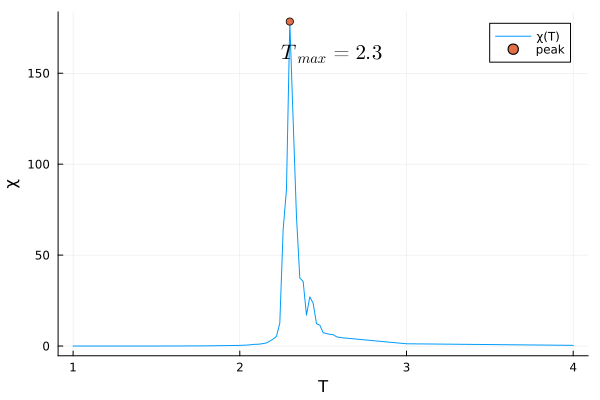

In [9]:
χ = []
for sect_idx in 1:length(setup_df.T)
    sect_start = setup_df.start_idx[sect_idx]
    sect_end = setup_df.end_idx[sect_idx]
    sect = sect_start:sect_end
    sect_T = setup_df.T[sect_idx]
    sect_m = abs.(M_arr[sect] / N)
    
    sect_equ_sweeps = setup_df.equ_sweeps[sect_idx]
    sect_meas_sweeps = setup_df.meas_sweeps[sect_idx]
    sect_n_meas = setup_df.n_meas[sect_idx]
    
    mean_m = mean(sect_m[sect_equ_sweeps:end])
    var_m = var(sect_m[sect_equ_sweeps:end])
    append!(χ, N/sect_T .* var_m)
end

peak_y = maximum(χ)
peak_x = setup_df.T[findfirst(χ .== peak_y)]
plot(setup_df.T, χ, xlabel="T", ylabel="χ", label="χ(T)")
scatter!([peak_x], [peak_y], label="peak")
annotate!(peak_x + (maximum(setup_df.T) - peak_x)*0.15, peak_y*0.9, "\$T_{max}=$(peak_x)\$")

## Correlation Time

Plot the autocorrelation function of the magnetization at a single section. regular vs log scale

In [10]:
min_idxs = ones(Int64, length(setup_df.T))
max_idxs = [5, 20, 100, 100, 125, 125, 100, 200, 150, 125, 250, 650, 250, 400, 350, 1500, 350, 1000, 600, 600, 150, 150, 125, 100, 100, 50, 25, 30, 50, 40, 25, 20, 20, 6, 5, 4, 4, 3]
length(max_idxs)

38

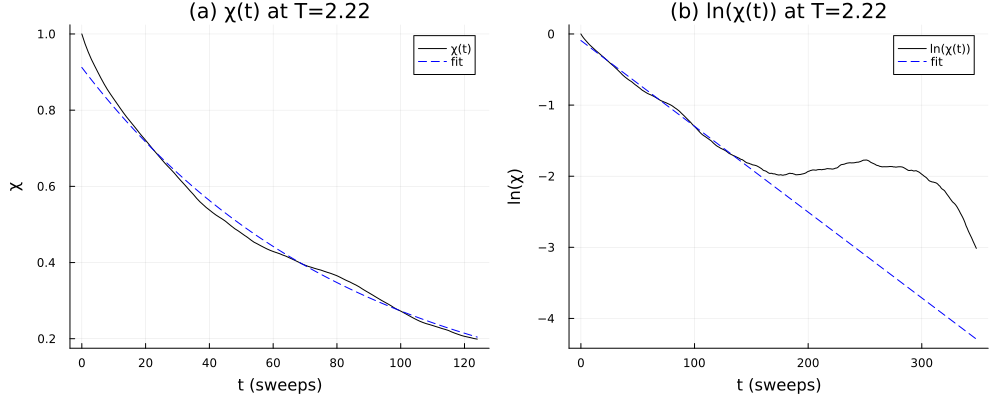

In [11]:
sect_idx = 22
min_cutoff_idx = min_idxs[sect_idx]
max_cutoff_idx = max_idxs[sect_idx]
low_val1 = 0.2
low_val2 = 0.05

sect_start = setup_df.start_idx[sect_idx] + setup_df.equ_sweeps[sect_idx]
sect_end = setup_df.end_idx[sect_idx]
sect = sect_start:sect_end
sect_T = T_arr[sect_start]
sect_m = M_arr[sect] ./ N
mean_m = mean(sect_m)

if ~all(sect_m .== mean_m)
    acorr = real.(ifft(abs.(fft(sect_m .- mean_m)).^2))
    acorr ./= acorr[1]
    firstlow1 = findfirst(x -> x < low_val1, acorr)
    firstlow2 = findfirst(x -> x < low_val2, acorr)
    
    fit_rng = min_cutoff_idx:max_cutoff_idx
    slope, inter = [(fit_rng .- 1) ones(length(fit_rng))] \ log.(acorr[fit_rng])
    
    p1 = plot(0:firstlow1-1, acorr[1:firstlow1], label="χ(t)", title="(a) χ(t) at T=$(sect_T)", ylabel="χ", color=:black)
    plot!(p1, 0:firstlow1-1, ℯ .^ ((0:firstlow1-1)*slope .+ inter), label="fit", style=:dash, linewidth=1, color=:blue)
    
    p2 = plot(0:firstlow2-1, log.(acorr[1:firstlow2]), label="ln(χ(t))", title="(b) ln(χ(t)) at T=$(sect_T)", ylabel="ln(χ)", color=:black)
    # plot!(p2, fit_rng .- 1, (fit_rng .- 1)*slope .+ inter, label="fit", style=:dash, linewidth=3, color=:blue)
    plot!(p2, 0:firstlow2-1, (0:firstlow2-1)*slope .+ inter, label="fit", style=:dash, linewidth=1, color=:blue)
    
    plot(p1, p2, layout=(1,2), size=(1000,400), xlabel="t (sweeps)", bottom_margin=5mm, left_margin=5mm)
else
    slope = 0
end


Correlation time per temperature

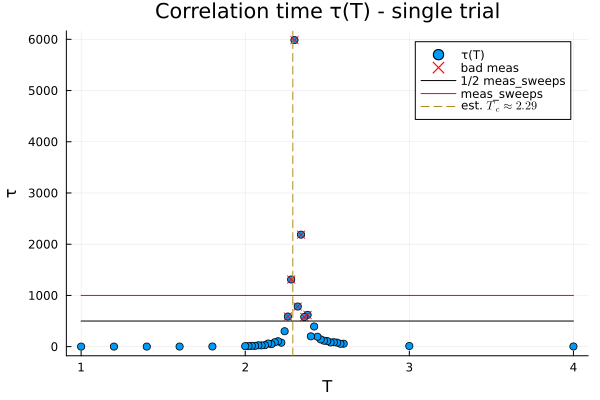

In [12]:
low_val = 0.05

corr_ts = []
for sect_idx in 1:length(setup_df.T)
    sect_start = setup_df.start_idx[sect_idx]
    sect_end = setup_df.end_idx[sect_idx]
    sect = sect_start:sect_end
    sect_T = T_arr[sect_start]
    sect_m = M_arr[sect] ./ N
    mean_m = mean(sect_m)
    
    if ~all(sect_m .== mean_m)
        acorr = real(ifft(abs.(fft(sect_m .- mean_m)).^2))
        firstlow = findfirst(x -> x < low_val, acorr)
        acorr = acorr ./ acorr[1]
        
        min_cutoff_idx = min_idxs[sect_idx]
        max_cutoff_idx = max_idxs[sect_idx]
        fit_rng = min_cutoff_idx:max_cutoff_idx
        
        slope, inter = [(fit_rng .- 1) ones(length(fit_rng))] \ log.(acorr[fit_rng])
        append!(corr_ts, -1/slope)
    else
        append!(corr_ts, 0)
    end
end

scatter(setup_df.T, corr_ts, title="Correlation time τ(T) - single trial", xlabel="T", ylabel="τ", label="τ(T)")
slow_idxs = (corr_ts .> setup_df.meas_sweeps ./ 2)
scatter!(setup_df.T[slow_idxs], corr_ts[slow_idxs], marker=:x, color=:red, label="bad meas")
plot!(setup_df.T, setup_df.meas_sweeps ./ 2, label="1/2 meas_sweeps", color=:black)
plot!(setup_df.T, setup_df.meas_sweeps, label="meas_sweeps", color=:red)

x = 1.8:0.01:5
Tc_est = 2.29
vline!([Tc_est], style=:dash, label="est. \$T_c\\approx 2.29\$")

In [13]:
# For each temperature, calculate the number of consequent measurements to skip to use only uncorrelated measurements
T_meas_skips = Int.(ceil.((corr_ts .+ 0.001) ./ (setup_df.meas_sweeps ./ 2)));

## Correlation Length (single measurement)

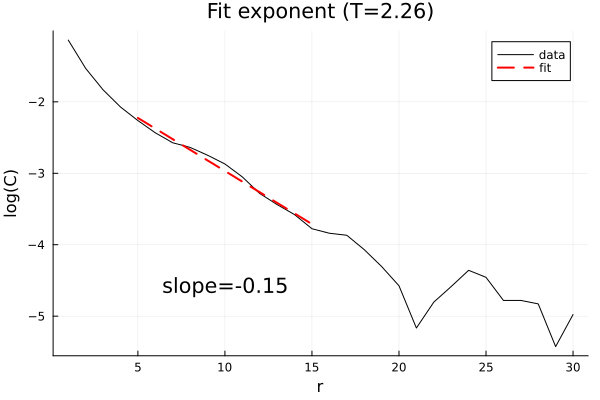

In [14]:
curr_T = setup_df.T[20]
curr_meas = 5
corr_x = 1:30
fit_idxs = 5:15 # Pick linear part for each measurement
curr = "$(base_path)\\$(trial_dir)\\T_$(curr_T)_meas_$(curr_meas).csv"

data = Matrix(CSV.read(curr, DataFrame, header=false))
a2fft = abs2.(fft(data))
a2fft[1,1] = 0
corrlen_fft = a2fft / N
_corrlen_f = abs.(ifft(corrlen_fft))[1:(L÷2), 1:(L÷2)]
corrlen_f = (_corrlen_f[1,:] + _corrlen_f[:, 1])/2


log_y = log.(corrlen_f[corr_x .+ 1])
plot(corr_x, log_y, title="Fit exponent (T=$(curr_T))", xlabel="r", ylabel="log(C)", color=:black, label="data")
slope, inter = [corr_x[fit_idxs] ones(length(fit_idxs))] \ log_y[fit_idxs]
plot!(corr_x[fit_idxs], slope .* corr_x[fit_idxs] .+ inter, style=:dash, linewidth=2, color=:red, label="fit")
annotate!(corr_x[10], maximum(log_y) + (minimum(log_y) - maximum(log_y)) * 0.8, @sprintf("slope=%.2f", slope))